<a href="https://colab.research.google.com/github/Sakthi-Vikkraman/WGAN-GP/blob/main/WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WGAN-GP - Wasserstein GAN



## Importing the libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.18.0'

## Loading and preprocessing the dataset

In [ ]:
(X_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
X_train = (X_train - 127.5) / 127.5

In [ ]:
buffer_size = 60000
batch_size = 256

In [ ]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

## Building the generator

- The same architecture of DCGAN

In [ ]:
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias=True, activation='tanh'))

  network.summary()

  return network

In [ ]:
generator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,945 (8.89 MB)

 Trainable params: 2,305,473 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [ ]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.8361226 ,  0.35218892, -0.4211469 , -0.2350948 ,  0.64936566,
        -1.304262  ,  0.14365442, -1.021924  , -0.00460661,  0.4372485 ,
         0.575657  , -0.25833133,  2.3863223 ,  1.4779527 , -2.2538447 ,
         0.89095116,  0.22296485, -0.5049278 ,  1.075326  , -0.5534492 ,
        -0.52283776, -0.601369  , -0.87679195, -1.308714  , -1.2310098 ,
         0.82614064, -0.30655423,  0.17411275, -0.11467317, -1.384306  ,
         2.1410446 , -0.18372792,  1.0733683 , -0.8021997 , -0.35242411,
        -0.01332506,  1.9019569 ,  0.2681357 ,  0.68407583,  1.0163591 ,
        -0.4194739 ,  1.5352341 , -0.24273619,  1.5406065 , -0.65375465,
         1.5739733 ,  0.7577065 , -0.5164709 , -0.5247891 , -0.46222532,
        -1.891568  , -1.1097096 ,  0.56426096,  2.0378075 ,  0.6481931 ,
        -0.5275855 , -1.2373554 ,  0.3347255 , -0.5279176 , -0.266908  ,
        -1.8155851 ,  1.5010489 ,  0.24895427,  1.3534449 ,  0.8569951 ,
 

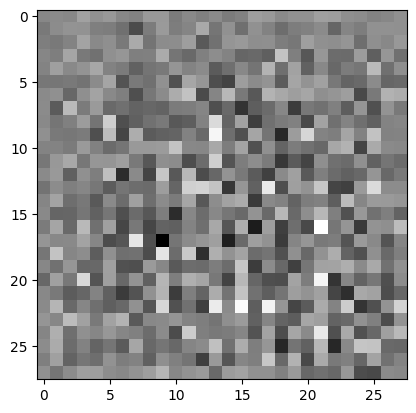

In [ ]:
generated_image = generator(noise, training = False)
plt.imshow(generated_image[0, :,:,0], cmap='gray');

## Building the discriminator

- The discriminator is also called as "critic"

In [ ]:
def build_discriminator():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [ ]:
discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
discriminator(generated_image, training = False) # logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00201574]], dtype=float32)>

In [ ]:
tf.sigmoid(-0.00030457)

<tf.Tensor: shape=(), dtype=float32, numpy=0.49992382526397705>


## Function to calculate **Wasserstein Loss**

The (*loss*) is the difference between the expected output of the discriminator for authentic images and the expected output of the discriminator for fake images (generated by the generator).

* The objective of the discriminator is to maximize this difference, while the objective of the generator is to minimize it.


In [ ]:
(0.2 + 0.9 + 0.99) / 3

0.6966666666666667

In [ ]:
-1 * tf.math.reduce_mean([0.2, 0.9, 0.99])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.6966667175292969>

In [ ]:
def loss_generator(fake_output):
  g_loss = -1. * tf.math.reduce_mean(fake_output) # need to minimize the difference by generator
  return g_loss

In [ ]:
def loss_discriminator(real_output, fake_output, gradient_penalty):
  c_lambda = 10
  d_loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + c_lambda * gradient_penalty
  return d_loss

## **Gradient Penalty**

- Beta parameters: https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear#:~:text=The%20hyper%2Dparameters%20%CE%B21,each%20training%20step%20(batch).

 To use Wasserstein loss, the discriminator must be **1-L** [(1-Lipschitz) continous](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/1-lipschitz-continuity-enforcement-GMPCt) - maximum 1.

To use 1-L we need **Gradient Penalty**.

This variation is called **WGAN-GP** (**G**radient **P**enalty)

(More information about Gradient Penalty [this article](https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead))

Steps to calculate gradient penalty:
1. Calculate an interpolated image from the real and fake image (`(real_image * epsilon + fake_image * (1 — epsilon))`)
2. Calculate the gradient of the discriminator output relative to the interpolated image. After, we calculate the gradient norm. Documentation: - tf.norm: https://www.tensorflow.org/api_docs/python/tf/norm
3. Finally, the penalty is calculated as an average of the square of (norm - 1), as we want the norm to be close to one.

We use [GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape)


In [ ]:
# def visualize_interpolated_images(real_images, fake_images, epsilon, num_images_to_show=4):
#     """
#     Visualizes interpolated images between real and fake images.
#     This function should be called outside of tf.function.
#     """
#     # Ensure inputs are tensors
#     real_images = tf.convert_to_tensor(real_images)
#     fake_images = tf.convert_to_tensor(fake_images)
#     epsilon = tf.convert_to_tensor(epsilon)

#     interpolated_images = real_images * epsilon + fake_images * (1 - epsilon)

#     if tf.shape(interpolated_images)[0] >= num_images_to_show:
#         images_to_plot = interpolated_images[:num_images_to_show]

#         # Scale the images back to 0-255 range for visualization
#         images_to_plot = (images_to_plot * 127.5 + 127.5)

#         # Ensure the tensor is in a format suitable for plotting (NumPy array)
#         # and handle the single channel if present
#         images_to_plot_np = images_to_plot.numpy() # .numpy() is safe here in eager mode
#         if images_to_plot_np.shape[-1] == 1:
#             images_to_plot_np = images_to_plot_np.squeeze(axis=-1) # Remove the last dimension

#         # Create a figure to display the images
#         fig, axes = plt.subplots(1, num_images_to_show, figsize=(num_images_to_show * 2, 2))
#         for i in range(num_images_to_show):
#             axes[i].imshow(images_to_plot_np[i], cmap='gray')
#             axes[i].axis('off')
#         plt.suptitle("Interpolated Images")
#         plt.show()

In [ ]:
@tf.function
def gradient_penalty(real, fake, epsilon):
  interpolated_images = real * epsilon + fake * (1 - epsilon)
  with tf.GradientTape() as tape:
    tape.watch(interpolated_images)
    scores = discriminator(interpolated_images)[0]
  gradient = tape.gradient(scores, interpolated_images)[0] # form the gradient of the image
  gradient_norm = tf.norm(gradient) # L2 normalization
  gp = tf.math.reduce_mean((gradient_norm - 1)**2)
  return gp

In [ ]:
# 0.2 -> 0.02 -> 0.002

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9) # in the paper these are default values, basically the beta param used to reduce the learning rate exponencially
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'checkpoints')
#print(checkpoint_prefix)
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

## Training and visualizing the results

In [ ]:
epochs = 30
noise_dim = 100
number_of_images = 16
seed = tf.random.normal([number_of_images, noise_dim])

In [ ]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[-2.3250394 ,  0.57431775,  0.2557153 , ...,  1.0220219 ,
         1.0920432 , -1.5034039 ],
       [-0.19731668,  1.1132497 ,  0.72629434, ...,  0.07867207,
        -0.3502165 ,  0.93711156],
       [-1.1569622 , -0.04210035,  1.5799072 , ...,  0.89541763,
        -2.4588106 ,  1.0105755 ],
       ...,
       [ 0.6266537 ,  1.2688043 ,  0.743125  , ..., -0.15631887,
         0.701399  ,  1.0971273 ],
       [ 0.53679866,  0.31788275, -0.75127107, ...,  0.5036044 ,
         0.26109856,  1.4354026 ],
       [ 0.46125475, -0.40397885, -0.91480935, ..., -0.7700668 ,
         1.503862  ,  0.74511653]], dtype=float32)>

In [ ]:
# def training_step(images):
#   noise = tf.random.normal([batch_size, noise_dim])
#   discriminator_extra_steps = 3

#   # Update discriminator (critic)
#   for i in range(discriminator_extra_steps):
#     with tf.GradientTape() as d_tape:
#       generated_images = generator(noise, training=True)
#       real_output = discriminator(images, training=True)
#       fake_output = discriminator(generated_images, training=True)

#       # WGAN discriminator loss: mean(fake_output) - mean(real_output)
#       d_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

#     discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
#     discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

#     # Weight clipping (enforcing 1-Lipschitz constraint)
#     for var in discriminator.trainable_variables:
#       var.assign(tf.clip_by_value(var, -0.01, 0.01))  # You can tune this clip value

#   # Update generator
#   with tf.GradientTape() as g_tape:
#     generated_images = generator(noise, training=True)
#     fake_output = discriminator(generated_images, training=True)

#     # WGAN generator loss: -mean(fake_output)
#     g_loss = -tf.reduce_mean(fake_output)

#   generator_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
#   generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))


In [ ]:
def training_step(images):
  noise = tf.random.normal([batch_size, noise_dim])
  discriminator_extra_steps = 3 #You update the discriminator 3 times per generator update.Helps it stay ahead of the generator.
  for i in range(discriminator_extra_steps):
    with tf.GradientTape() as d_tape:
      generated_images = generator(noise, training = True)
      real_output = discriminator(images, training = True)
      fake_output = discriminator(generated_images, training = True)
      epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0) #This samples random coefficients t∼U[0,1] for interpolation.Shape is broadcasted for image tensors.
      gp = gradient_penalty(images, generated_images, epsilon)

      d_loss = loss_discriminator(real_output, fake_output, gp) # critic loss
    discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  with tf.GradientTape() as g_tape:
    generated_images = generator(noise, training = True)
    fake_output = discriminator(generated_images, training = True) #Generates new fake images.Gets their critic score from the discriminator.
    g_loss = loss_generator(fake_output) #Generator wants to maximize the critic's score:E[D( x~ )], i.e., make fake look real.But because you use gradient descent, you minimize −E[D( x~ )]
  generator_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables)) #Backpropagate and update the generator’s weights.

Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [ ]:
def create_and_save_images(model, epoch, test_input):
  preds = model(test_input, training = False)
  fig = plt.figure(figsize = (4,4))
  for i in range(preds.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('img_epoch_{:04d}'.format(epoch))
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    initial = time.time()
    for img_batch in dataset:
      if len(img_batch) == batch_size:
        training_step(img_batch)
    #display.clear_output(wait = True)
    create_and_save_images(generator, epoch + 1, seed)
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Time taken to process epoch {} was {} seconds'.format(epoch + 1, time.time() - initial))

  #display.clear_output(wait = True)
  create_and_save_images(generator, epochs, seed)
  generator.save('generator.h5')

In [ ]:
train(X_train, epochs)

AttributeError: in user code:

    File "<ipython-input-32-d08bd4232301>", line 13, in gradient_penalty  *
        images_to_plot_np = images_to_plot.numpy()

    AttributeError: 'SymbolicTensor' object has no attribute 'numpy'


In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

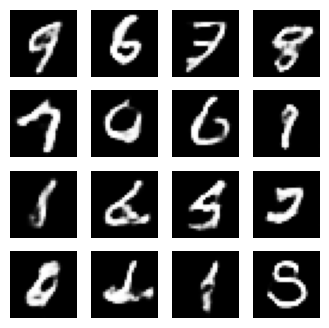

In [ ]:
seed_input = tf.random.normal([number_of_images, noise_dim])
preds = generator(seed_input, training = False)
fig = plt.figure(figsize = (4,4))
for i in range(preds.shape[0]):
  plt.subplot(4,4,i+1)
  plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
  plt.axis('off')

> More implementations:

* https://github.com/robbiebarrat/art-DCGAN (based on DCGAN)
* https://github.com/tdrussell/IllustrationGAN (based on DCGAN)
* https://github.com/viuts/wgan-animefaces (based on WGAN)